
Tamaño imagen 1: (350, 735, 3) pix




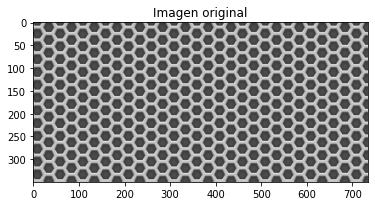

In [181]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline  

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt
# Importamos librerías para manejo de tiempo
import time

# Ahora quiero verla como imagen en color
img1 = cv.imread('metalgrid.jpg')
gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)

# Dimensión de la imagen
print('\nTamaño imagen 1: {} pix'.format(img1.shape))
print('\n')

################# FIG: originales ##############################################
# Muestro la imagen con matplotlib
plt.imshow(img1,cmap="gray")
plt.title("Imagen original")
plt.show()

Blur 0.0005767345428466797 segundos 
 


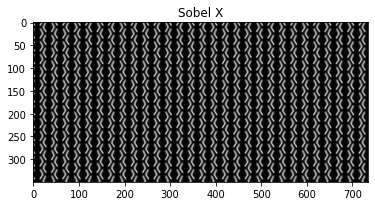

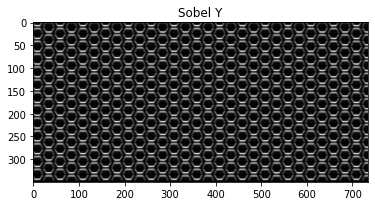

In [182]:

# Suavizado Gaussiano
#====================

start = time.time()

blur = cv.GaussianBlur(gray,(5,5),0)

elapsed = time.time()-start
print('Blur {} segundos \n '.format(elapsed))

# Gradientes
#===========
# Aplicamos Sobelx en 'float32' y luego convertimos de nuevo a 8-bit para evitar overflow
sobelx_64 = cv.Sobel(blur,cv.CV_32F,1,0,ksize=3)
absx_64 = np.absolute(sobelx_64)
sobelx_8u1 = absx_64/absx_64.max()*255
sobelx_8u = np.uint8(sobelx_8u1)
# Muestro la imagen
#==================
plt.imshow(sobelx_8u,cmap="gray")
plt.title("Sobel X")
plt.show()
print("\n")

# De igual modo para Sobely
sobely_64 = cv.Sobel(blur,cv.CV_32F,0,1,ksize=3)
absy_64 = np.absolute(sobely_64)
sobely_8u1 = absy_64/absy_64.max()*255
sobely_8u = np.uint8(sobely_8u1)
# Muestro la imagen
#==================
plt.imshow(sobely_8u,cmap="gray")
plt.title("Sobel Y")
plt.show()



 Maximo gradiente:  255

 ================= Magnitud ((350, 735))===================== 

[[  0   8   0 ...   0   0   0]
 [ 54  47  22 ...  51  51  51]
 [104 107  71 ...  55  55  55]
 ...
 [  2   6  12 ...   4   3   2]
 [  1   1   2 ...   4   3   1]
 [  0   0   0 ...   3   2   0]]




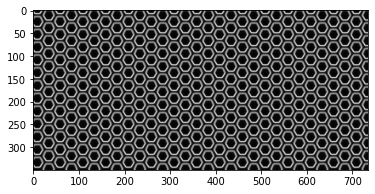




 ================ Angulo ((350, 735)) ========================
 
[[  0.       180.       180.       ...   0.       180.         0.      ]
 [ 90.       115.94229  130.6013   ... -89.383934 -91.8476   -90.      ]
 [ 90.       123.25001  140.7824   ... -88.85423  -92.2906   -90.      ]
 ...
 [-90.       -68.198586 -68.198586 ...  45.        56.309933  90.      ]
 [-90.       -90.       -78.69006  ...  33.690067  45.        90.      ]
 [  0.         0.         0.       ...   0.         0.         0.      ]]




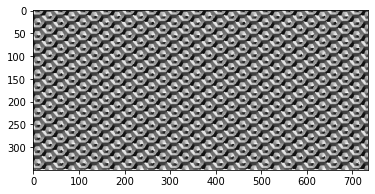

In [183]:
# De los gradiente calculamos Magnitud y lo pasamos a 8-bit (Opcional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255
mag = np.uint8(mag)

max_mag = np.max(mag)
print("\n Maximo gradiente: ",max_mag)
print("\n ================= Magnitud ({})===================== \n".format(mag.shape))
print(mag)
print("\n")
plt.imshow(mag,cmap="gray")
plt.show()
print("\n")
# Encontramos la Dirección y la pasamos a grados
theta = np.arctan2(sobely_64, sobelx_64)
angle = np.rad2deg(theta)

print("\n ================ Angulo ({}) ========================\n ".format(angle.shape))
print(angle)
print("\n")
plt.imshow(angle,cmap="gray")
plt.show()



 ================== tiempo ejecución canny ==================================

No-máximos 5.402393102645874 segundos
Histéresis 0.006866931915283203 segundos
Armado imagen bordes 0.5033373832702637 segundos




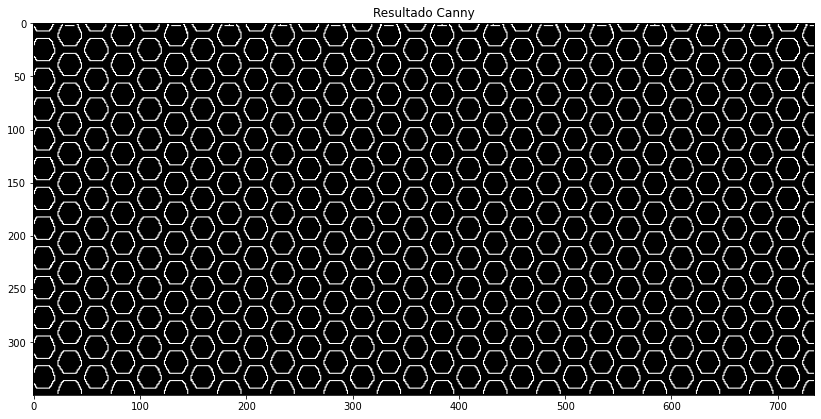

In [184]:
# Supresión de no-máximos
#========================
start = time.time()

# Encontramos los píxels vecinos (b,c) en la dirección (redondeadea) del gradiente y aplicamos la supresión de no-máximos
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)

for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Supresión de no-máximos
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
            
        else:
            Non_max[i,j] = 0


elapsed = time.time()-start
print("\n ================== tiempo ejecución canny ==================================\n")
print('No-máximos {} segundos'.format(elapsed))

# Umbralizado por histéresis
#===========================
start = time.time()

#Ajustamos los valores para obtener mejor definicion del borde.
UmbralAlto = 35 
UmbralBajo = 15

M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)

# Si la intensidad de un borde es mayor a 'UmbralAlto' es seguro un umbral, debajo de 'UmbralBajo' seguro no es
strong_i, strong_j = np.where(Non_max >= UmbralAlto)
zeros_i, zeros_j = np.where(Non_max < UmbralBajo)

# Bordes débiles
weak_i, weak_j = np.where((Non_max <= UmbralAlto) & (Non_max >= UmbralBajo))

# Setear el mismo valor a todos los tipos de píxel
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

elapsed = time.time()-start
print('Histéresis {} segundos'.format(elapsed))

# Armo la imagen de bordes
#=========================
start = time.time()
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0


elapsed = time.time()-start
print('Armado imagen bordes {} segundos'.format(elapsed))
print('\n')

plt.figure(figsize=(14,8))
plt.imshow(out,cmap="gray")
plt.title("Resultado Canny")
plt.show()




Bordes rojos con dirección  [-45°, 0°]
Bordes amarillo con dirección  <0°, 45°]
Bordes verde con dirección <45°, 100°]




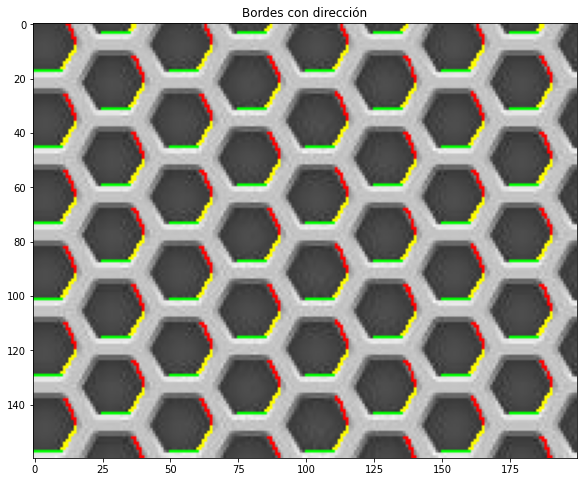

In [185]:
#Graficar para un angulo de -45° a 0°
for i in range(1,M-1):
  for j in range(1,N-1):
      an=int(angle[i,j].round())
      if out[i,j]==255 and (an>=-45 and an<=0) :
         img1[i,j]=(255,0,0) 
         #print(mag[i,j])
print("\n ==============================================\n")
print("\033[91m"+"Bordes rojos con dirección  [-45°, 0°]")

#Graficar para un angulo de 0° a 45°
for i in range(1,M-1):
  for j in range(1,N-1):
      an=int(angle[i,j].round())
      if out[i,j]==255 and (an>0 and an<=45) :
         img1[i,j]=(255,255,0) 
         #print(mag[i,j])

print("\033[1;33m"+"Bordes amarillo con dirección  <0°, 45°]"+'\033')

#Graficar para un angulo de 45° a 100°
for i in range(1,M-1):
  for j in range(1,N-1):
      an=int(angle[i,j].round())
      if out[i,j]==255 and (an>45 and an<=100) :
         img1[i,j]=(0,255,0) 
         #print(mag[i,j])

print("\033[32m"+"Bordes verde con dirección <45°, 100°]"+'\033') 
print("\n")

# Muestro solo una parte de la imagen para mejor visibilidad
#==================
imageOut = img1[60:220,280:480]
plt.figure(figsize=(14,8))
plt.imshow(imageOut)
plt.title("Bordes con dirección")
plt.show()

**CONCLUSIONES:** al analizar el algoritmo de canny, sus gradientes y sus ángulos de los pixeles de los bordes, se verificó que los bordes diagonales y horizontales no tienen un ángulo constante, sino tienen un ángulo variable con valores proximos. Por tanto se usó ángulos por intervalos para poder pintar los bordes con mayor gradiente. 